In [6]:
import torch, pickle, scipy.sparse as sp
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import pytorch_lightning as pl

from pathlib import Path
import sys, os

script_dir = Path().resolve()
sys.path.append(str(script_dir))
dann_dir = script_dir / 'dann'
sys.path.append(str(dann_dir))
print(script_dir)


# now regular import works
from lightning_dann import DANNModule


# from lightning_dann import DANNModule
import numpy as np

import scanpy as sc

/oscar/data/rsingh47/wli115/universalgene/src


In [8]:
data_dir = script_dir / 'data'
sys.path.append(str(data_dir))

tm_adata_dir = data_dir / 'tabula_muris' / 'preprocessed' 

# tm_adata_path = r'../data/tabula_muris/preprocessed/tm_adata_all.pkl'
# tm_adata_path = r'../data/tabula_muris/preprocessed/tm_adata_test.pkl'
tm_adata_path = tm_adata_dir /'tm_adata_test.pkl'
with open(tm_adata_path, 'rb') as f:
    tm_adata = pickle.load(f)

In [9]:
!pwd

/users/wli115/data/rsingh47/wli115/universalgene/src


In [12]:
# model = DANNModule.load_from_checkpoint("checkpoints/dann_full.ckpt")
# model = DANNModule.load_from_checkpoint("checkpoints/dann_full_epochs100.ckpt")
# model = DANNModule.load_from_checkpoint("checkpoints/dann_train_tissue_epochs100.ckpt")
# model = DANNModule.load_from_checkpoint("checkpoints/dann_train_tissue_epochs500.ckpt") # linear encoder
model = DANNModule.load_from_checkpoint("dann/checkpoints/mha_encoder_epochs100/val_loss1.144.ckpt") # MHA encoder
encoder = model.encoder
encoder.eval()

Encoder(
  (fc1): Linear(in_features=2000, out_features=512, bias=True)
  (attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
  )
  (fc2): Linear(in_features=512, out_features=128, bias=True)
)

In [13]:
encoder.eval()
X = tm_adata.X.toarray()
scaler = StandardScaler(with_mean=False)
X_scaled = scaler.fit_transform(X)
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
with torch.no_grad():
    embeddings = encoder(X_tensor).cpu().numpy()  # Move back to CPU for numpy conversion

In [14]:
tm_adata.obsm['X_latent'] = embeddings
tm_adata = tm_adata.copy()
        
sc.pp.neighbors(tm_adata, use_rep='X_latent')  # Compute neighbors using latent space
sc.tl.umap(tm_adata)  # Run UMAP

/tmp/ipykernel_636238/3078530829.py:1: ImplicitModificationWarning: Setting element `.obsm['X_latent']` of view, initializing view as actual.
  tm_adata.obsm['X_latent'] = embeddings


In [15]:
tm_adata

AnnData object with n_obs × n_vars = 61774 × 2000
    obs: 'age', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation', 'tech', 'FACS.selection', 'n_counts', 'batch', 'celltype_tech_availability'
    var: 'n_cells-0', 'n_cells-1', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'log1p', 'hvg', 'neighbors', 'umap'
    obsm: 'X_latent', 'X_umap'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

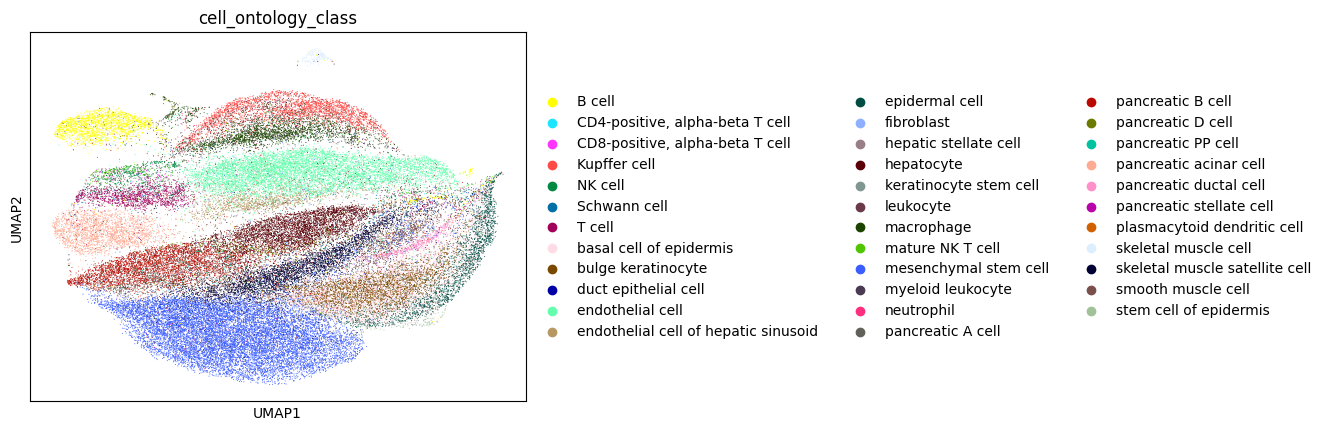

In [16]:
output_folder = r'./figures/test'
os.makedirs(output_folder, exist_ok=True)
fig = sc.pl.umap(
        tm_adata, color='cell_ontology_class', show=True, return_fig=True
    )
# fig.savefig(f"{output_folder}/celltype.png")
# plt.close(fig)

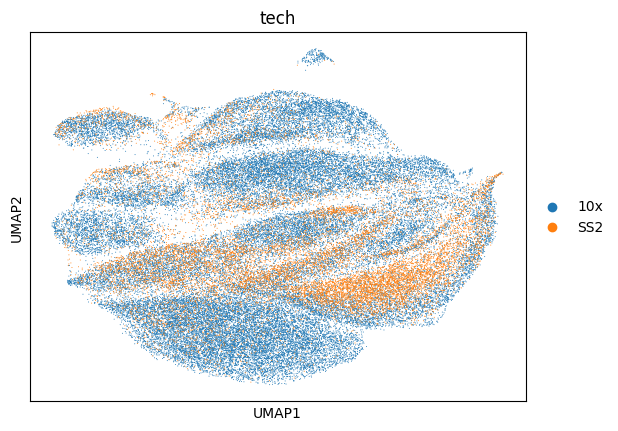

In [17]:
fig = sc.pl.umap(
        tm_adata, color='tech', show=True, return_fig=True
    )
fig.savefig(f"{output_folder}/tech.png")

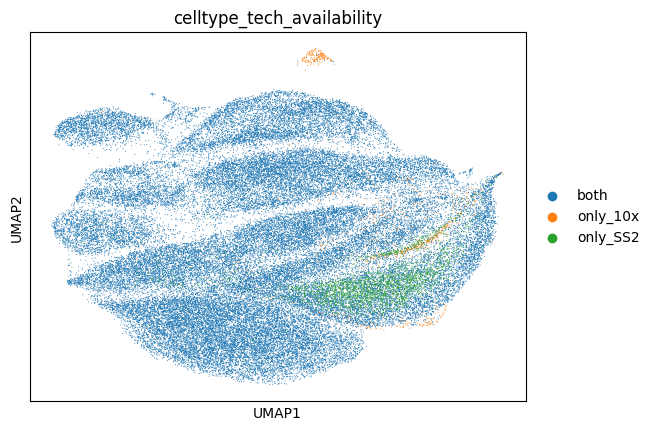

In [18]:
fig = sc.pl.umap(
        tm_adata, color='celltype_tech_availability', show=True, return_fig=True
    )
# fig.savefig(f"{output_folder}/availability.png")